In [141]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


In [142]:
import pennylane as qml
from pennylane import numpy as np


def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

In [143]:
def add_k_sign(k, wires):
    
    #sign handling
    k = int(np.binary_repr(k,len(wires)),2)
    
    # qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)
    
def add_k_sign_inverse(k, wires):
    
    #sign handling
    k = int(np.binary_repr(k,len(wires)),2)
    
    qml.QFT(wires=wires)
    for j in range(len(wires)):
        new_j = len(wires)-1-j
        qml.RZ(-1* k * np.pi / (2**new_j), wires=wires[new_j])
    qml.adjoint(qml.QFT)(wires=wires)

In [144]:
def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    # qml.adjoint(qml.QFT)(wires=wires_solution)
    
def multiplication_inverse(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            new_i = len(wires_k)-1-i
            new_j = len(wires_m)-1-j
            coeff = -1*2 ** (len(wires_m) + len(wires_k) - new_i - new_j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[new_i], wires_m[new_j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

In [145]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10,11,12,13]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1000)
# dev = qml.device('qiskit.ibmq', wires=2, backend='ibmq_qasm_simulator', ibmqx_token="XXX")

n_wires = len(dev.wires)


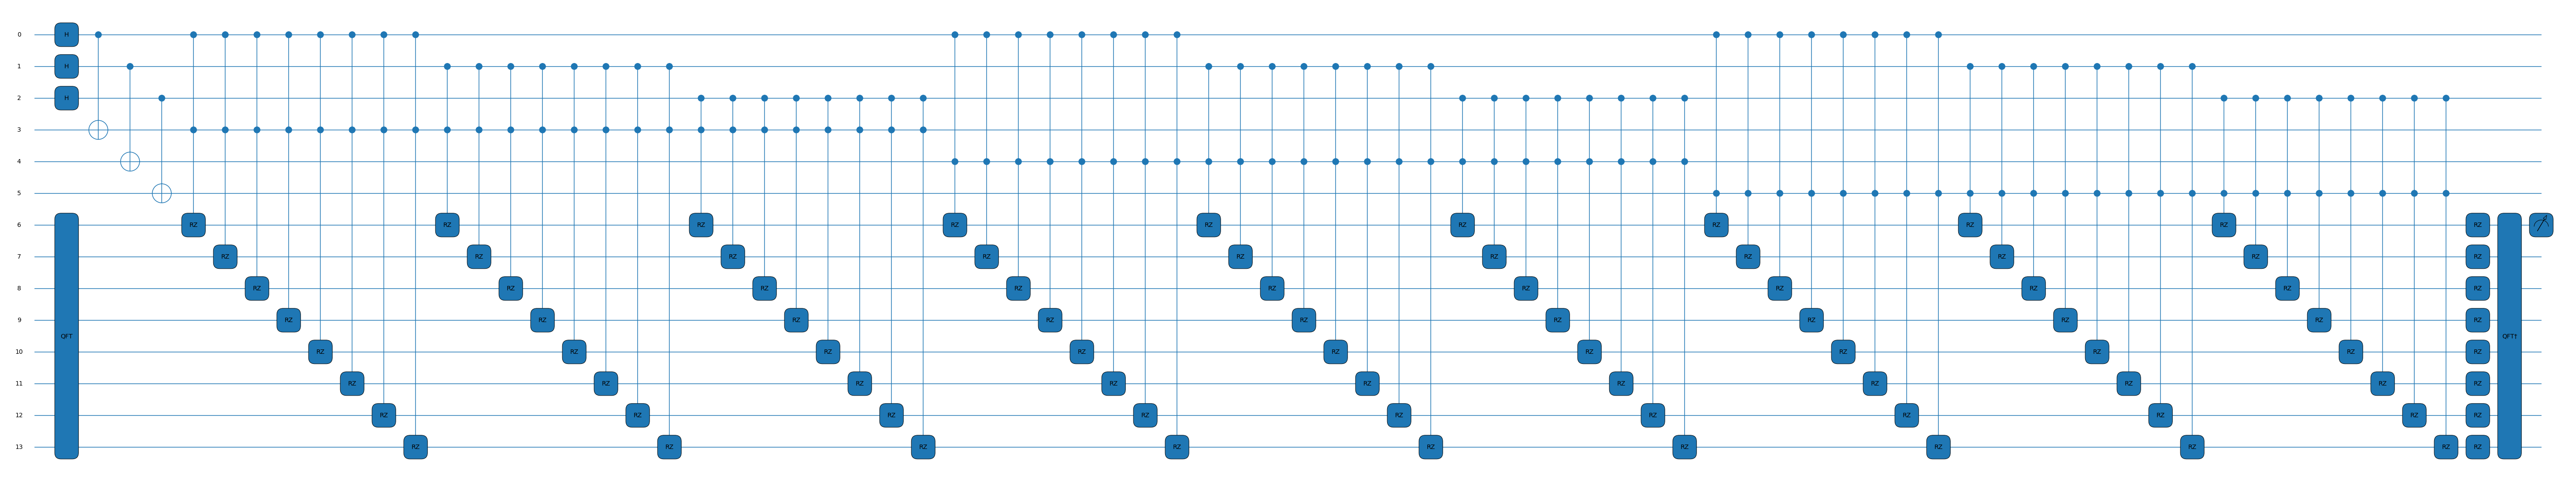

In [146]:
@qml.qnode(dev)
def circuit(a_t):
    a,t = a_t
    
    # # m and k codification
    # qml.BasisEmbedding(m, wires=wires_m)
    # qml.BasisEmbedding(k, wires=wires_k)
    
    for i in wires_m:
        qml.Hadamard(wires=i)

    qml.CNOT(wires=[0,3])
    qml.CNOT(wires=[1,4])
    qml.CNOT(wires=[2,5])
    

    # Apply circuittiplication
    multiplication(wires_m, wires_k, wires_solution)
    # add_k_sign(a,wires=wires_solution)
    add_k_sign(t,wires=wires_solution)
    

    
    # return qml.probs(wires=wires_solution)
    # return qml.probs(wires=[0,1,2,3,4,5])
    return qml.expval(qml.PauliZ(wires=6))

input = (2,1)


qml.draw_mpl(circuit, show_all_wires=True)(input)
plt.show()

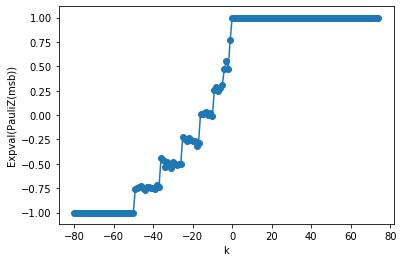

In [147]:

x=[i for i in range(-80,75)]
y=[]
for i in x:
    # print('===')
    # print(circuit((2,3,2,i)))
    val = circuit((0,i))

    y.append(val)


# plot scatter plot with x and y data
plt.scatter(x, y)

plt.xlabel('k')
plt.ylabel('Expval(PauliZ(msb))')
  
# plot with x and y data
plt.plot(x, y)

